In [1]:
%load_ext autoreload
# %load_ext autoreload
%autoreload 2
import pickle
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.linalg import expm 
from numpy.linalg import norm
from datetime import datetime
from scipy.io import loadmat
from scipy.optimize import minimize
from scipy.spatial.distance import squareform,pdist
from scipy.stats import wilcoxon, norm 

from scipy.stats import ttest_1samp
from sklearn.utils import shuffle
from sklearn.manifold import MDS
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import multivariate_normal
from scipy.stats import zscore
from matplotlib import cm
from utils import *
from plotting import *
# from plotting import *
from matplotlib import cm 
import matplotlib as mpl 
from joblib import Parallel, delayed
import time
from IPython.core.debugger import set_trace
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

# MLP revisions

In [2]:

N_STIM = 25
N_CTX = 2
N_HIDDEN = 100
N_OUT = 1
N_RUNS = 30
N_ITER = 10000
LRATE = 5e-3
SCALE_WHXS = np.asarray([1e-2,1e-1,2e-1,3e-1,4e-1,1,2,3])

N_FACTORS = len(SCALE_WHXS)
scale_labels = [str(ii) for ii in SCALE_WHXS]

# # open results (was 'results_nnet_main_withacc_withmlp_stepscaled.pickle)

with open('D:/DPHIL_01_TREES_FMRI/Paper/code/Data/Simulations/mlp/results_nnet_main_withacc_withmlp_stepscaled.pickle','rb') as f:
        results = pickle.load(f)



        

## are weight changes larger in the output layer under lazy learning?

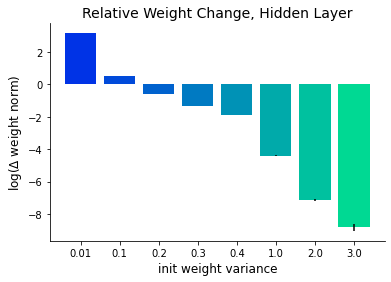

In [38]:
%matplotlib inline
SCALE_WHXS = np.asarray([1e-2,1e-1,2e-1,3e-1,4e-1,1,2,3])


ws = results['w_relchange_hxs'][:,:,-1]

N_RUNS = ws.shape[1]
cols = cm.winter(np.linspace(.2,.85,8))

plt.figure()
for ii in range(ws.shape[0]):
    plt.bar(ii,np.mean(np.log(np.abs(ws[ii,:])),0),yerr=np.std(np.log(np.abs(ws[ii,:])),0)/np.sqrt(N_RUNS),zorder=3,color=cols[ii,:])

plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=scale_labels)
plt.title('Relative Weight Change, Hidden Layer',fontsize=14)
plt.ylabel('log($\Delta$ weight norm)',fontsize=12)
plt.xlabel('init weight variance',fontsize=12)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)




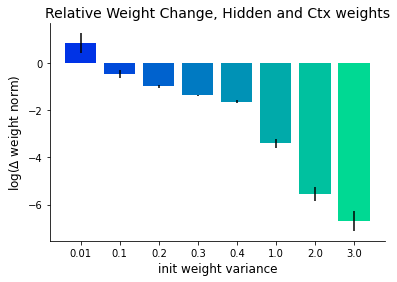

In [39]:

SCALE_WHXS = np.asarray([1e-2,1e-1,2e-1,3e-1,4e-1,1,2,3])


ws = results['w_relchange_hxs'][:,:,-1]
wc = results['w_relchange_hxc'][:,:,-1]
N_RUNS = ws.shape[1]
cols = cm.winter(np.linspace(.2,.85,8))

plt.figure()
for ii in range(ws.shape[0]):
    plt.bar(ii,np.mean(np.log(np.abs(np.concatenate((ws[ii,:],wc[ii,:]),axis=0))),0),yerr=np.std(np.log(np.abs(np.concatenate((ws[ii,:],wc[ii,:]),axis=0))),0)/np.sqrt(N_RUNS),zorder=3,color=cols[ii,:])

plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=scale_labels)
plt.title('Relative Weight Change, Hidden and Ctx weights',fontsize=14)
plt.ylabel('log($\Delta$ weight norm)',fontsize=12)
plt.xlabel('init weight variance',fontsize=12)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)




In [49]:
%matplotlib qt
SCALE_WHXS = np.asarray([1e-2,1e-1,2e-1,3e-1,4e-1,1,2,3])


ws = results['w_relchange_yh'][:,:,-1]

N_RUNS = ws.shape[1]
cols = cm.winter(np.linspace(.2,.85,8))

plt.figure()
for ii in range(ws.shape[0]):
    plt.bar(ii,np.mean(np.log(np.abs(ws[ii,:])),0),yerr=np.std(np.log(np.abs(ws[ii,:])),0)/np.sqrt(N_RUNS),zorder=3,color=cols[ii,:])

plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=scale_labels)
plt.title('Relative Weight Change, Output Layer',fontsize=14)
plt.ylabel('log($\Delta$ weight norm)',fontsize=12)
plt.xlabel(r'init $\sigma_w$',fontsize=12)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)




##  but overall, smaller weight norm under rich than lazy?

In [50]:
def comp_norms(weights):
    norms = np.empty((8,N_RUNS))
    for ii in range(8):
        for jj in range(N_RUNS):
            norms[ii,jj] = np.linalg.norm(weights[ii,jj,:,:].flatten())
    return norms

def plot_norms(norms,titlestr,zorder=1,colors=np.repeat([1,0,0],8,axis=0)):
    for ii in range(8):
        plt.bar(ii,np.mean(norms[ii,:],0),yerr=np.std(norms[ii,:],0)/np.sqrt(len(norms[ii,:])),zorder=zorder,color=colors[ii,:])
    plt.title(titlestr,fontsize=14)
    plt.ylabel('norm')
    plt.xticks(ticks=np.arange(0,8),labels=[str(i) for i in SCALE_WHXS])
    plt.xlabel('scaling factor')


f = plt.figure(figsize=(5.7,3.3))

norms = np.empty((8,N_RUNS))
cols = cm.winter(np.linspace(.2,.85,8))
for ii in range(8):
    for jj in range(N_RUNS):
        # norms[ii,jj] = np.linalg.norm(np.concatenate((results['all_w_hxs'][ii,jj,:,:].flatten(),results['all_w_hxc'][ii,jj,:,:].flatten(),results['all_w_yh'][ii,jj,:,:].flatten()),axis=0))
        norms[ii,jj] = np.linalg.norm(results['all_w_yh'][ii,jj,:,:].flatten())
        
plot_norms(norms,'Endpoint Norms, output weights',zorder=3,colors=cols)
plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=scale_labels)

plt.ylabel('weight norm',fontsize=12)
plt.xlabel(r'init $\sigma_w$',fontsize=12)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
lims = plt.xlim()

plt.xlim(lims)

plt.yticks(ticks=np.arange(0,10,2))
plt.tight_layout()

## show that lazy network would never converge to rich solution:
- "for comparison, networks were trained on the same number of epochs" 
- plot delta W as time progresses, should be zero for lazy after a few iterations
- show how adding L2 regulariser added to lazy network pushes it down to rich net

In [87]:
%matplotlib qt
with open('D:/DPHIL_01_TREES_FMRI/Paper/code/Experiments/Simulations/results_mlp_main.pkl','rb') as f:
    results = pickle.load(f)
w = np.concatenate((results['w_delta_hxs'],results['w_delta_hxc']),axis=1)
cols = cm.winter(np.linspace(.2,.85,8))
for ii,c in enumerate(cols):
    plt.plot(np.abs((w[ii,:,:10000])).mean(0),color=c)
plt.yscale('linear')
cmap_new = mpl.colors.ListedColormap(cm.winter(np.linspace(.2,.85,50)))
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap_new,norm=norm)
plt.title(r"$|\Delta W|$ on each training iteration, input weights")
cb = plt.colorbar(sm,ticks=[0,1])
cb.ax.set_yticklabels(['rich','lazy'])
cb.ax.set_ylabel('Training Regime',fontsize=12)


w = results['w_delta_yh']
plt.figure()
for ii,c in enumerate(cols):
    plt.plot(np.abs((w[ii,:,:10000])).mean(0),color=c)
plt.yscale('linear')
cmap_new = mpl.colors.ListedColormap(cm.winter(np.linspace(.2,.85,50)))
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap_new,norm=norm)
plt.title(r"$|\Delta W|$ on each training iteration, output weights")
cb = plt.colorbar(sm,ticks=[0,1])
cb.ax.set_yticklabels(['rich','lazy'])
cb.ax.set_ylabel('Training Regime',fontsize=12)

w = results['w_delta_hxs']
plt.figure()
for ii,c in enumerate(cols):
    plt.plot(np.abs((w[ii,:,:5000])).mean(0),color=c)
plt.yscale('linear')
cmap_new = mpl.colors.ListedColormap(cm.winter(np.linspace(.2,.85,50)))
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap_new,norm=norm)
plt.title(r"$|\Delta W|$ on each training iteration, stimulus weights")
cb = plt.colorbar(sm,ticks=[0,1])
cb.ax.set_yticklabels(['rich','lazy'])
cb.ax.set_ylabel('Training Regime',fontsize=12)


w = results['w_delta_hxc']
plt.figure()
for ii,c in enumerate(cols):
    plt.plot(np.abs((w[ii,:,:5000])).mean(0),color=c)
plt.yscale('linear')
cmap_new = mpl.colors.ListedColormap(cm.winter(np.linspace(.2,.85,50)))
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap_new,norm=norm)
plt.title(r"$|\Delta W|$ on each training iteration, context weights")
cb = plt.colorbar(sm,ticks=[0,1])
cb.ax.set_yticklabels(['rich','lazy'])
cb.ax.set_ylabel('Training Regime',fontsize=12)


Text(0, 0.5, 'Training Regime')

In [98]:
def comp_norms(weights):
    norms = np.empty((8,N_RUNS))
    for ii in range(8):
        for jj in range(N_RUNS):
            norms[ii,jj] = np.linalg.norm(weights[ii,jj,:,:].flatten())
    return norms

def plot_norms(norms,titlestr,zorder=1,colors=np.repeat([1,0,0],8,axis=0)):
    for ii in range(8):
        plt.bar(ii,np.mean(norms[ii,:],0),yerr=np.std(norms[ii,:],0)/np.sqrt(len(norms[ii,:])),zorder=zorder,color=colors[ii,:])
    plt.title(titlestr,fontsize=6)
    plt.ylabel('norm')
    plt.xticks(ticks=np.arange(0,8),labels=[str(i) for i in SCALE_WHXS])
    plt.xlabel('scaling factor')


with open('D:/DPHIL_01_TREES_FMRI/Paper/code/Data/Simulations/mlp/results_nnet_l2loss.pickle','rb') as f:
    norm_res = pickle.load(f)

N_RUNS = 20
norms = np.empty((8,N_RUNS))
for ii in range(8):
    for jj in range(N_RUNS):
        norms[ii,jj] = np.linalg.norm(np.concatenate((norm_res['all_w_hxs'][ii,jj,:,:].flatten(),norm_res['all_w_hxc'][ii,jj,:,:].flatten(),norm_res['all_w_yh'][ii,jj,:,:].flatten()),axis=0))

norm_l2 = np.mean(norms,1)[0]

mm = 1/25.4
f = plt.figure(figsize=(55*mm,50*mm),dpi=300)

norms = np.empty((8,N_RUNS))
cols = cm.winter(np.linspace(.2,.85,8))
for ii in range(8):
    for jj in range(N_RUNS):
        norms[ii,jj] = np.linalg.norm(np.concatenate((results['all_w_hxs'][ii,jj,:,:].flatten(),results['all_w_hxc'][ii,jj,:,:].flatten(),results['all_w_yh'][ii,jj,:,:].flatten()),axis=0))
        
plot_norms(norms,'Endpoint Norms, all weights',zorder=3,colors=cols)
plt.xticks(ticks=np.arange(0,len(SCALE_WHXS)),labels=scale_labels)

plt.ylabel('weight norm',fontsize=6)
plt.xlabel(r'initial $\sigma_w$',fontsize=6)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
lims = plt.xlim()
bs = plt.plot(lims,[norm_l2]*2,'r--',zorder=4,linewidth=1)
plt.xlim(lims)
plt.legend(bs,['L2 penalty on lazy init (var=3.0)'],fontsize=6,frameon=False)
plt.yticks(ticks=np.arange(0,160,50))
plt.tight_layout()

In [111]:
N_RUNS = 30
LAMBDA = np.flip(np.linspace(0,0.1,8))
N_FACTORS = len(LAMBDA)
scale_labels = [str(ii) for ii in np.round(LAMBDA,2)]

with open('D:/DPHIL_01_TREES_FMRI/Paper/code/Data/Simulations/mlp/results_nnet_l2loss.pickle','rb') as f:
    norm_res = pickle.load(f)
norms = np.empty((8,N_RUNS))
for ii in range(8):
    for jj in range(N_RUNS):
        norms[ii,jj] = np.linalg.norm(np.concatenate((norm_res['all_w_hxs'][ii,jj,:,:].flatten(),norm_res['all_w_hxc'][ii,jj,:,:].flatten()),axis=0))

mm = 1/25.4
f = plt.figure(figsize=(55*mm,50*mm),dpi=300)

cols = cm.winter(np.linspace(.2,.85,8))
        
plot_norms(norms,'Endpoint Norms, all weights',zorder=3,colors=cols)
plt.xticks(ticks=np.arange(0,len(LAMBDA)),labels=scale_labels)

plt.ylabel('weight norm',fontsize=6)
plt.xlabel(r'regularisation strength $\lambda$',fontsize=6)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
lims = plt.xlim()
plt.xlim(lims)

plt.yticks(ticks=np.arange(0,160,50))
plt.tight_layout()


mm = 1/25.4
fig = plt.figure(figsize=(55*mm,55*mm),dpi=300)

plt.subplot(2,1,1)
plot_norms(norms,'Endpoint Norms, all weights',zorder=3,colors=cols)
# plt.xticks(ticks=np.arange(0,len(LRATE)),labels=[],fontsize=6)
plt.xticks(ticks=np.arange(0,len(LAMBDA)),labels=scale_labels,fontsize=6,rotation=90)
plt.yticks(ticks=np.arange(0,150,50),fontsize=6)
plt.ylabel(r'$\| W_{hidden}\|$',fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim((0,170))
plt.yticks(ticks=[0,50,100,150])
lims = plt.xlim()
# plt.ylabel('weight norm',fontsize=6)
plt.xlabel(r'regularisation strength $\lambda$',fontsize=6)
plt.xlim(lims)
plt.tight_layout()

ws = norm_res['w_relchange_hxs'][:,:,-1]
# print(ws.shape)
plt.subplot(2,1,2)
for ii in range(ws.shape[0]):
    print(np.mean(np.log(np.abs(ws[ii,:])),0))
    plt.bar(ii,np.mean(np.log(np.abs(ws[ii,:])),0),yerr=np.std(np.log(np.abs(ws[ii,:])),0)/np.sqrt(N_RUNS),zorder=3,color=cols[ii,:])
plt.xticks(ticks=np.arange(0,len(LAMBDA)),labels=scale_labels,fontsize=6,rotation=90)
# ax = plt.gca()
# ax.set_xticklabels(rotation=90)
plt.ylim((-10,5))
plt.yticks([-10,-5,0,5])
plt.yticks(fontsize=6)
plt.ylabel(r'log $\left(\Delta\|W_{hidden}\|\right)$',fontsize=6)

plt.xlabel(r'regularisation strength $\lambda$',fontsize=6)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle(r'Lazy-Init Net ($\sigma_{init} = 0.3$ with L2 Regulariser)')
plt.tight_layout()

-0.059415560476289
-0.061979035670125575
-0.06855363682151953
-0.08746451179613184
-0.14123695185025095
-0.28144225776638493
-0.6748012514026157
-8.812484620218603


In [103]:
with open('D:/DPHIL_01_TREES_FMRI/Paper/code/Data/Simulations/mlp/results_nnet_l2loss.pickle','rb') as f:
    results = pickle.load(f)

LAMBDA = np.flip(np.linspace(0,0.1,8))
N_FACTORS = len(LAMBDA)
scale_labels = [str(ii) for ii in LAMBDA]

_, dmat,xyz = gen_modelrdms(monitor=0)

_,c_mu,c_err = stats_fit_rdms(dmat,results['all_y_hidden'])

fig=plt.figure(figsize=(67*(1/25.4), 43*(1/25.4)), dpi=300, facecolor='w', edgecolor='k',linewidth=.5)

  
plot_rsa_fits(c_mu,c_err,runvalue=LAMBDA,runlabel=r'regularisation strength $\lambda$',titlestr='Model Fits to Hidden Layer')
plt.ylim((-.1,1))
plt.xticks(ticks=LAMBDA,labels=np.round(LAMBDA,2))
plt.xlim((0.11,-0.01))

plt.tight_layout()


## are patterns in rich regime (near-) orthogonal?

In [51]:
# # open results (was 'results_nnet_main_withacc_withmlp_stepscaled.pickle)
# with open('/media/timo/data/DPHIL_01_TREES_FMRI/Paper/code/Data/Simulations/mlp/results_nnet_main_withacc_withmlp_stepscaled.pickle','rb') as f:
#         results = pickle.load(f)
SCALE_WHXS = np.asarray([1e-2,1e-1,2e-1,3e-1,4e-1,1,2,3])

N_FACTORS = len(SCALE_WHXS)
scale_labels = [str(ii) for ii in SCALE_WHXS]
plt.figure()
plt.plot(SCALE_WHXS,results['hidden_dotprod'].mean(1)[:,1],'ko-')
plt.yscale('linear')
_ = plt.xticks(ticks=np.arange(0,3.5,.5),labels=np.arange(0,3.5,.5))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set(xlabel=r'init weight scale $\sigma$',ylabel=r'$x_a^Tx_b$',title='Dot product between task A and task B patterns')


[Text(0.5, 0, 'init weight scale $\\sigma$'),
 Text(0, 0.5, '$x_a^Tx_b$'),
 Text(0.5, 1.0, 'Dot product between task A and task B patterns')]

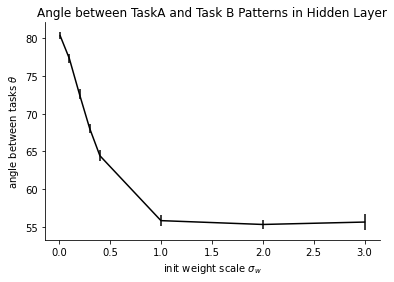

In [53]:
%matplotlib inline
plt.figure()
angles = []
for i in range(len(results['all_y_hidden'])):
    angs = []
    for ir in range(30):
        vec = results['all_y_hidden'][i,ir,:,:]
        vec1 = np.mean(vec[:,:25],1)
        vec2 = np.mean(vec[:,25:],1)
        angs.append(np.rad2deg(np.arccos((vec1.T@vec2)/(np.sqrt(sum([v**2 for v in vec1]))*np.sqrt(sum([v**2 for v in vec2]))))))
    angles.append(angs)
angles = np.asarray(angles)
_ = plt.errorbar(SCALE_WHXS,angles.mean(1),yerr=np.std(angles,1)/np.sqrt(30),color='k')
_ = plt.xticks(ticks=np.arange(0,3.5,.5),labels=np.arange(0,3.5,.5))
ax = plt.gca()
ax.set(xlabel=r'init weight scale $\sigma_w$',ylabel=r'angle between tasks $\theta$',title='Angle between TaskA and Task B Patterns in Hidden Layer')
ax.spines['top'] .set_visible(False)   
ax.spines['right'].set_visible(False)

In [ ]:
# within task RSA
# 1. model rdms: only branchiness and only leafiness
# 2. mask out task A or task B (rest to nan) in model and brain rdms 
# 3. regress


## Visualise Hidden layer weights

In [122]:
# visualise hidden layer weights, sort them by output unit type (mixed selective, task a or task b selective )

def plot_hidden_weights(results,regime='rich'):
    reg_id = int(regime!='rich') * -1
    unit_cols = [[250/255, 147/255, 30/255],[0/255, 6/255, 189/255],[4/255, 162/255, 201/255]]
    # get unit ids:
    yout = results['all_y_hidden'][reg_id,0,:,:]
    x = np.vstack((np.nanmean(yout[:,0:25],1).T,np.nanmean(yout[:,25:],1).T))
    # local units
    mask_local = ~(np.all(x,axis=0)) & np.any(x,axis=0)
    mask_a = np.all(np.vstack((x[0,:]>0,x[1,:]==0)),axis=0)
    mask_b = np.all(np.vstack((x[0,:]==0,x[1,:]>0)),axis=0)
    mask_mixed = ~mask_local

    ws = results['all_w_hxs'][reg_id,0,:,:]
    ws = [ws[mask_a,:],ws[mask_b,:],ws[mask_mixed,:]]    
    unit_cols = [c for c,w in zip(unit_cols,ws) for i in range(len(w))]
    ws = np.concatenate(ws,axis=0)
    
    mm = 1/25.4
    f,axs= plt.subplots(10,10,figsize=(50*mm,80*mm),dpi=300)
    axs = axs.ravel()
    for ax,c,w in zip(axs,unit_cols,ws):
        ax.imshow(w.reshape(5,5))
        [i.set_linewidth(1) for i in ax.spines.values()]
        [i.set_color(c) for i in ax.spines.values()]
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.suptitle(f'Hidden Layer Weights, {regime} Learning'.title(),fontsize=6)
    f.patch.set_facecolor('white')



plot_hidden_weights(results,regime='lazy')
plot_hidden_weights(results,regime='rich')


## Magnitude of readout weights
are readout weights larger for task-selective units?

In [135]:
# visualise hidden layer weights, sort them by output unit type (mixed selective, task a or task b selective )
N_RUNS = results['all_y_hidden'].shape[1]

def plot_output_weights(results,regime='rich'):
    reg_id = int(regime!='rich') * -1
    unit_cols = [[250/255, 147/255, 30/255],[0/255, 6/255, 189/255],[4/255, 162/255, 201/255]]
    ws = []
    for run_id in range(N_RUNS):
        # get unit ids:
        yout = results['all_y_hidden'][reg_id,run_id,:,:]
        x = np.vstack((np.nanmean(yout[:,0:25],1).T,np.nanmean(yout[:,25:],1).T))
        # local units
        mask_local = ~(np.all(x,axis=0)) & np.any(x,axis=0)
        mask_a = np.all(np.vstack((x[0,:]>0,x[1,:]==0)),axis=0)
        mask_b = np.all(np.vstack((x[0,:]==0,x[1,:]>0)),axis=0)
        mask_mixed = ~mask_local

        wr = results['all_w_yh'][reg_id,run_id,:].flatten()
        wr = [np.abs(u).mean(0) for u in [wr[mask_a],wr[mask_b],wr[mask_mixed]]]
        ws.append(wr)
        
    ws = np.asarray(ws)
    mm = 1/25.4
    f,ax= plt.subplots(1,1,figsize=(60*mm,50*mm),dpi=300)
    for i in range(3):
        ax.bar(i,ws[:,i].mean(0),yerr=np.std(ws[:,i],ddof=1)/np.sqrt(N_RUNS),color=unit_cols[i])
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels(['task a','task b', 'agnostic'],fontsize=6)
    ax.set_xlabel('unit type',fontsize=6)
    ax.set_ylabel('output weight magnitude',fontsize=6)
    ax.set_yticks(np.arange(0,0.81,0.2))
    ax.set_ylim(0,0.8)
    ticks = ax.get_yticks()
    ax.set_yticklabels(np.round(np.array(ticks),2),fontsize=6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
        
    plt.title(f'{regime} Learning'.title(),fontsize=6)
    f.patch.set_facecolor('white')


plot_output_weights(results,regime='lazy')
plt.tight_layout()
plot_output_weights(results,regime='rich')
plt.tight_layout()


## ablation: can you remove task-selective units from lazy net without affecting performance?

note: even the task-selective units aren't axis aligned under lazy, so this is probably nothing to worry about

In [137]:
with open('D:/DPHIL_01_TREES_FMRI/Paper/code/Experiments/Simulations/results_mlp_main.pkl','rb') as f:
    results = pickle.load(f)
# with open('/media/timo/data/DPHIL_01_TREES_FMRI/Paper/code/Data/Simulations/mlp/results_nnet_main_withacc_withmlp_stepscaled.pickle','rb') as f:
#         results = pickle.load(f)

f,axs = plt.subplots(1,2,figsize=(10,6))
axs = axs.flatten()
axs[0].bar(np.arange(3),[results['acc_y_ref'][0,:,:].mean(),results['acc_ablate_task'][0,:,:].mean(),results['acc_ablate_mixed'][0,:,:].mean()],yerr=np.squeeze(np.array([[results['acc_y_ref'][0,:].std(0,ddof=1),results['acc_ablate_task'][0,:].std(0,ddof=1),results['acc_ablate_mixed'][0,:].std(0,ddof=1)]])/np.sqrt(N_RUNS)))
axs[0].set(xticks=[0,1,2],xticklabels=['all','task-specific removed','task-agnostic removed'],title='rich learning',ylim=(.5,1))
axs[1].bar(np.arange(3),[results['acc_y_ref'][-1,:,:].mean(),results['acc_ablate_task'][-1,:,:].mean(),results['acc_ablate_mixed'][-1,:,:].mean()],yerr=np.squeeze(np.array([[results['acc_y_ref'][-1,:].std(0,ddof=1),results['acc_ablate_task'][-1,:].std(0,ddof=1),results['acc_ablate_mixed'][-1,:].std(0,ddof=1)]])/np.sqrt(N_RUNS)))
axs[1].set(xticks=[0,1,2],xticklabels=['all','task-specific removed','task-agnostic removed'],title='lazy learning',ylim=(.5,1))

[[<matplotlib.axis.XTick at 0x152c4365af0>,
 [Text(0, 0, 'all'),
  Text(1, 0, 'task-specific removed'),
  Text(2, 0, 'task-agnostic removed')],
 Text(0.5, 1.0, 'lazy learning'),
 (0.5, 1.0)]

## selectivity: regression-based selectivity analysis 
just like for the NHPs

In [121]:
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
from utils import mk_experiment
from IPython.core.debugger import set_trace
from copy import deepcopy


# with open('/media/timo/data/DPHIL_01_TREES_FMRI/Paper/code/Experiments/Simulations/results_mlp_main.pkl','rb') as f:
#     results = pickle.load(f)
# with open('/media/timo/data/DPHIL_01_TREES_FMRI/Paper/code/Data/Simulations/mlp/results_nnet_main_withacc_withmlp_stepscaled.pickle','rb') as f:
#         results = pickle.load(f)

_, c, y,f = mk_experiment('both')
# regressors: l_a,b_a,l_b,b_b 
c = (np.array(c)>0).astype(int)
dmat = zscore(np.tile(np.array(f),(1,2))*np.repeat(c,2,axis=0).T,axis=0)
betas = np.empty((8,N_RUNS,100,4))
pvals = np.empty((8,N_RUNS,100,4))
fdr_sig = np.empty((8,N_RUNS,100,4))

# loop over runs, regimes and units

for r in range(N_RUNS):
    for s in range(8):
        for u in range(100):
            y = results['all_y_hidden'][s,r,u,:]            
            y = y[:,np.newaxis]            
            # catch dead units:
            if np.any(np.isnan(y)):
                betas[s,r,u,:] = [np.nan]*4                
            else:
                modelfits = sm.OLS(y,dmat).fit()
                betas[s,r,u,:] = modelfits.params.flatten()
                pvals[s,r,u,:] = modelfits.pvalues.flatten()
        for i in range(4):
            fdr_sig[s,r,:,i],_ = fdrcorrection(pvals[s,r,:,i])

            

proportions = []
for s in range(8):
    proportions_r = []
    for r in range(N_RUNS):
        p = fdr_sig[s,r,:,:].astype('int')
        n_sig = np.any(p,axis=1).sum()
        idx_ta = ((p[:,0]==0) & (p[:,1]==1)) & ((p[:,2]==0) & (p[:,3]==0))
        idx_tb = ((p[:,0]==0) & (p[:,1]==0)) & ((p[:,2]==1) & (p[:,3]==0))
        idx_mix = ((p[:,0]==1) & (p[:,1]==1)) | ((p[:,2]==1) & (p[:,3]==1))
        idx_branch = ((p[:,0]==0) & (p[:,1]==1)) & ((p[:,2]==0) & (p[:,3]==1))
        idx_leaf = ((p[:,0]==1) & (p[:,1]==0)) & ((p[:,2]==1) & (p[:,3]==0))
        task_fract = [sum(idx_ta)/n_sig,sum(idx_tb)/n_sig,sum(idx_mix)/n_sig,sum(idx_branch)/n_sig,sum(idx_leaf)/n_sig]
        task_fract.append(1-sum(task_fract))
        proportions_r.append(task_fract)
    proportions.append(deepcopy(proportions_r))
proportions = np.array(proportions)
f,axs = plt.subplots(2,4,figsize=(10,10))
axs = axs.ravel()
for i,ax in enumerate(axs):
    ax.bar(np.arange(6),proportions[i,:,:].mean(0),yerr=np.std(proportions[i,:,:],ddof=1,axis=0)/np.sqrt(N_RUNS))
    ax.set(ylim=(0,1))



ModuleNotFoundError: No module named 'statsmodels'

## Ablation: does removing only task A units affect task A performance (and vice versa?)

In [148]:
# bars: a/b: all, removed a, removed b, removed mixed 
# one fig rich, one for lazy
mm = 1/25.4
f,axs = plt.subplots(1,2,figsize=(50*mm,50*mm),dpi=300)
axs = axs.flatten()
# rich 
mu = np.array([results['acc_ablate_none_both'][0,:,:].mean(0),results['acc_ablate_mixed_both'][0,:,:].mean(0),results['acc_ablate_a_both'][0,:,:].mean(0),results['acc_ablate_b_both'][0,:,:].mean(0)])
err = np.array([results['acc_ablate_none_both'][0,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_mixed_both'][0,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_a_both'][0,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_b_both'][0,:,:].std(0,ddof=1)/np.sqrt(N_RUNS)])
print(mu)
b1 = axs[0].bar(np.arange(4)-.2,mu[:,0],yerr=err[:,0],color='darkblue',width=.4)
b2 = axs[0].bar(np.arange(4)+.2,mu[:,1],yerr=err[:,1],color='orange',width=.4)
axs[0].set(xticks=[0,1,2,3])
axs[0].set_xticklabels(['none','task agnostic','task a sel.','task b sel.'],fontsize=6)
axs[0].set_title('Rich Learning',fontsize=6)
axs[0].set_xlabel('ablated units',fontsize=6)
axs[0].set_ylabel('accuracy (%)',fontsize=6)
axs[0].set_yticks(np.arange(0,1.05,0.25))
axs[0].set_yticklabels(np.arange(0,105,25),fontsize=6)
axs[0].set_ylim(.5,1)
for label in axs[0].get_xticklabels():
    
    label.set_rotation(90)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# lazy
mu = np.array([results['acc_ablate_none_both'][-1,:,:].mean(0),results['acc_ablate_mixed_both'][-1,:,:].mean(0),results['acc_ablate_a_both'][-1,:,:].mean(0),results['acc_ablate_b_both'][-1,:,:].mean(0),])
err = np.array([results['acc_ablate_none_both'][-1,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_mixed_both'][-1,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_a_both'][-1,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_b_both'][-1,:,:].std(0,ddof=1)/np.sqrt(N_RUNS)])
print(mu)
b1 = axs[1].bar(np.arange(4)-.2,mu[:,0],yerr=err[:,0],color='darkblue',width=.4)
b2 = axs[1].bar(np.arange(4)+.2,mu[:,1],yerr=err[:,1],color='orange',width=.4)
axs[1].set(xticks=[0,1,2,3])
axs[1].set_xticklabels(['none','task agnostic','task a sel.','task b sel.'],fontsize=6)
axs[1].set_title('Lazy Learning',fontsize=6)
axs[1].set_xlabel('ablated units',fontsize=6)
axs[1].set_ylabel('accuracy (%)',fontsize=6)
axs[1].set_yticks(np.arange(0,1.05,0.25))
axs[1].set_yticklabels(np.arange(0,105,25),fontsize=6)
axs[1].set_ylim(.5,1)
for label in axs[1].get_xticklabels():
    
    label.set_rotation(90)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

[[1.         1.        ]
 [0.99833333 1.        ]
 [0.72333333 1.        ]
 [1.         0.69833333]]
[[1.         1.        ]
 [0.94166667 0.91666667]
 [0.96833333 0.96166667]
 [0.96166667 0.94666667]]


## Ablation: does ablating linear units impact performance on congruent trials?

In [153]:
mm = 1/25.4
f,axs = plt.subplots(1,2,figsize=(50*mm,50*mm),dpi=300)

axs = axs.flatten()
# rich 
mu = np.array([results['acc_ablate_none_congr'][0,:,:].mean(0),results['acc_ablate_task_congr'][0,:,:].mean(0),results['acc_ablate_mixed_congr'][0,:,:].mean(0)])
err = np.array([results['acc_ablate_none_congr'][0,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_task_congr'][0,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_mixed_congr'][0,:,:].std(0,ddof=1)/np.sqrt(N_RUNS)])
print(mu)
b1 = axs[0].bar(np.arange(3)-.2,mu[:,0],yerr=err[:,0],color='green',width=.4)
b2 = axs[0].bar(np.arange(3)+.2,mu[:,1],yerr=err[:,1],color='red',width=.4)
axs[0].set(xticks=[0,1,2])
axs[0].set_xticklabels(['none','task sel.','task agn.'],fontsize=6,rotation=90)
axs[0].set_title('Rich Learning',fontsize=6)
axs[0].set_xlabel('ablated units',fontsize=6)
axs[0].set_ylabel('accuracy (%)',fontsize=6)
axs[0].set_yticks(np.arange(0,1.05,0.25))
axs[0].set_yticklabels(np.arange(0,105,25),fontsize=6)
axs[0].set_ylim(.5,1)
axs[0].legend(['congruent','incongruent'],fontsize=6,loc=1,frameon=False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

 
# lazy
mu = np.array([results['acc_ablate_none_congr'][-1,:,:].mean(0),results['acc_ablate_task_congr'][-1,:,:].mean(0),results['acc_ablate_mixed_congr'][-1,:,:].mean(0)])
err = np.array([results['acc_ablate_none_congr'][-1,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_task_congr'][-1,:,:].std(0,ddof=1)/np.sqrt(N_RUNS),results['acc_ablate_mixed_congr'][-1,:,:].std(0,ddof=1)/np.sqrt(N_RUNS)])
print(mu)
b1 = axs[1].bar(np.arange(3)-.2,mu[:,0],yerr=err[:,0],color='green',width=.4)
b2 = axs[1].bar(np.arange(3)+.2,mu[:,1],yerr=err[:,1],color='red',width=.4)
axs[1].set(xticks=[0,1,2])
axs[1].set_xticklabels(['none','task sel.','task agn.'],fontsize=6,rotation=90)
axs[1].set_title('Lazy Learning',fontsize=6)
axs[1].set_xlabel('ablated units',fontsize=6)
axs[1].set_ylabel('accuracy (%)',fontsize=6)
axs[1].set_yticks(np.arange(0,1.05,0.25))
axs[1].set_yticklabels(np.arange(0,105,25),fontsize=6)
axs[1].set_ylim(.5,1)
axs[1].legend(['congruent','incongruent'],fontsize=6,loc=1,frameon=False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
plt.tight_layout()

[[1.         1.        ]
 [0.8625     0.56875   ]
 [0.99791667 1.        ]]
[[1.         1.        ]
 [0.8625     0.825     ]
 [0.925      0.92708333]]


## Congruency analysis
does performance differ between congruent and incongruent trials?

In [154]:
def compute_congruency_acc(cmat,cmat_true):    
    """computes accuracy on congruent and incongruent trials

    Args:
        cmat (np array): choices
        cmat_true (np array): ground truth category labels

    Returns:
        int: accuracies on congruent and incongruent trials
    """
    c = (cmat>0) == (cmat_true>0)
    acc_congruent = (np.mean(c[:2,:2])+np.mean(c[3:,3:]))/2
    acc_incongruent = (np.mean(c[:2,3:])+np.mean(c[3:,:2]))/2
    return acc_congruent, acc_incongruent


_, c, y,f = mk_experiment('both')
y = np.squeeze(y)
ya = y[:25].reshape(5,5)
yb = y[25:].reshape(5,5)

accs = np.empty((8,N_RUNS,2))
for s in range(8):
    ta = results['all_y_out'][s,:,:,:][:,:,:25].reshape(30,5,5)
    tb = results['all_y_out'][s,:,:,:][:,:,25:].reshape(30,5,5)
    for r in range(N_RUNS):
        aca1,aca2 = compute_congruency_acc(ta[1,:,:],ya)        
        acb1,acb2 = compute_congruency_acc(tb[1,:,:],yb)
        accs[s,r,0] = (aca1+acb1)/2
        accs[s,r,1] = (aca2+acb2)/2


In [155]:
plt.bar(np.arange(2),accs[0,:].mean(0),yerr=accs[0,:].std(0)/np.sqrt(N_RUNS))
plt.xticks(ticks=[0,1],labels=('congruent','incongruent'))
plt.title('congruency effect in nnet')
# no difference between congruent and incongruent stimuli

Text(0.5, 1.0, 'congruency effect in nnet')

## fit parameterised model to hidden layer patterns
can we show that the compression, orthogonality etc scores are task diagnostic?

In [6]:
from scipy.stats import kruskal, mannwhitneyu, wilcoxon



In [14]:
from scipy.stats import norm

In [12]:
from scipy.stats import shapiro
print(shapiro(compression_rates[-1]))

ShapiroResult(statistic=0.9547593593597412, pvalue=0.22630925476551056)


In [15]:
from scipy.stats import ttest_ind


are compression rates different? kruskal wallis: z=14.0005, p=0.0000
is compression larger in rich than lazy: t=-49.7760, p=0.0000
is compression significant in rich: z=4.7821, p=0.0000
is compression significant in lazy: z=0.0720, p=0.9426


are angles different? kruskal wallis: z=1.9976, p=0.0458
is angles larger in rich than lazy: z=2.8312, p=0.0046
is rotation significantly different from 90 in rich: z=4.7821, p=0.0000
is rotation significantly different from 90 in lazy: z=4.7821, p=0.0000


are offsets different? kruskal wallis: z=8.4022, p=0.0000
is offset larger in rich than lazy: z=2.5651, p=0.0103
is offset significant in rich: z=4.7821, p=0.0000
is offset significant in lazy: z=4.7821, p=0.0000


In [11]:
%matplotlib qt
def spiceUp_figure(fh,xlabels):
    plt.figure(fh.number)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    plt.xticks(ticks=np.arange(len(xlabels)),labels=xlabels)


with open('parammod_results.pkl','rb') as f:
    data = pickle.load(f)



## Impact of  Learning Rate

In [76]:
with open('D:/DPHIL_01_TREES_FMRI/Paper/code/Experiments/Simulations/results_mlp_lr.pkl','rb') as f:
    results = pickle.load(f)

%matplotlib qt
# compute how much slower nnet converge compared to lazy learning:
LRATE = np.asarray([1e-3,2e-3,3e-3,4e-3,5e-3,6e-3,7e-3,8e-3,9e-3,1e-2])

cols = cm.winter(np.linspace(.2,.85,len(LRATE)))
cols = np.array([cols[0]]*10)
is_ceil = []
mm = 1/25.4
fig = plt.figure(figsize=(55*mm,40*mm),dpi=300)
for ii in range(len(LRATE)):
    try:
        this_conv = np.where(np.mean(results['all_accuracies'][ii,:,:],0)==1)[0][0]
    except IndexError:
        this_conv = 10000
    is_ceil.append(this_conv)
    # plt.barh(ii,this_conv,color=cols[ii,:])    
    plt.bar(ii,this_conv,color=cols[ii,:])    


plt.xlabel('learning rate $\eta$',fontsize=6)
plt.ylabel('Episodes until convergence',fontsize=6)
plt.xticks(ticks=np.arange(0,len(LRATE)),labels=LRATE,fontsize=6,rotation=90)
ticks = plt.yticks()[0]
plt.yticks(ticks=ticks,fontsize=6)
ax = plt.gca()
ax.set_ylim((0,10000))
ticks = np.arange(0,10001,2500)
ax.set_yticks(ticks)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r'Rich-Initialised Net ($\sigma_{init} = 0.01$)')
plt.show()
plt.tight_layout()
print('iter at which ceiling is hit: ' + str(is_ceil))
xty = np.round(np.asarray([ii/is_ceil[-1] for ii in is_ceil]),2)
print('faster than lazy learning (times): ' + str(xty))


iter at which ceiling is hit: [4035, 2360, 1370, 1002, 832, 821, 3116, 1939, 10000, 10000]
faster than lazy learning (times): [0.4  0.24 0.14 0.1  0.08 0.08 0.31 0.19 1.   1.  ]


In [77]:
with open('D:/DPHIL_01_TREES_FMRI/Paper/code/Experiments/Simulations/results_mlp_lr_lazy.pkl','rb') as f:
    results = pickle.load(f)

%matplotlib qt
# compute how much slower nnet converge compared to lazy learning:
LRATE = np.asarray([1e-3,2e-3,3e-3,4e-3,5e-3,6e-3,7e-3,8e-3,9e-3,1e-2])

cols = cm.winter(np.linspace(.2,.85,len(LRATE)))
cols = np.array([cols[-1]]*10)
is_ceil = []
mm = 1/25.4
fig = plt.figure(figsize=(55*mm,40*mm),dpi=300)
for ii in range(len(LRATE)):
    try:
        this_conv = np.where(np.mean(results['all_accuracies'][ii,:,:],0)==1)[0][0]
    except IndexError:
        this_conv = 10000
    is_ceil.append(this_conv)
    # plt.barh(ii,this_conv,color=cols[ii,:])    
    plt.bar(ii,this_conv,color=cols[ii,:])    


plt.xlabel('learning rate $\eta$',fontsize=6)
plt.ylabel('Episodes until convergence',fontsize=6)
plt.xticks(ticks=np.arange(0,len(LRATE)),labels=LRATE,fontsize=6,rotation=90)
ticks = plt.yticks()[0]
plt.yticks(ticks=ticks,fontsize=6)
ax = plt.gca()
ax.set_ylim((0,10000))
ticks = np.arange(0,10001,2500)
ax.set_yticks(ticks)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r'Lazy-Initialised Net ($\sigma_{init} = 0.3$)')
plt.show()
plt.tight_layout()
print('iter at which ceiling is hit: ' + str(is_ceil))
xty = np.round(np.asarray([ii/is_ceil[-1] for ii in is_ceil]),2)
print('faster than lazy learning (times): ' + str(xty))


iter at which ceiling is hit: [254, 115, 120, 56, 44, 82, 164, 103, 234, 384]
faster than lazy learning (times): [0.66 0.3  0.31 0.15 0.11 0.21 0.43 0.27 0.61 1.  ]


In [78]:
def plot_norms(norms,titlestr,zorder=1,colors=np.repeat([1,0,0],len(LRATE),axis=0)):
    for ii in range(len(LRATE)):
        plt.bar(ii,np.mean(norms[ii,:],0),yerr=np.std(norms[ii,:],0)/np.sqrt(len(norms[ii,:])),zorder=zorder,color=colors[ii,:])
    # plt.title(titlestr,fontsize=14)
    plt.ylabel('norm')
    plt.xticks(ticks=np.arange(0,len(LRATE)),labels=[str(i) for i in LRATE])
    # plt.xlabel('scaling factor')

with open('D:/DPHIL_01_TREES_FMRI/Paper/code/Experiments/Simulations/results_mlp_lr.pkl','rb') as f:
    results = pickle.load(f)

ws = results['w_relchange_hxs'][:,:,-1]
N_RUNS = ws.shape[1]



mm = 1/25.4
fig = plt.figure(figsize=(55*mm,55*mm),dpi=300)

plt.subplot(2,1,1)

norms = np.empty((len(LRATE),N_RUNS))
cols = cm.winter(np.linspace(.2,.85,len(LRATE)))
cols = np.array([cols[0]]*10)
for ii in range(len(LRATE)):
    for jj in range(N_RUNS):
        norms[ii,jj] = np.linalg.norm(np.concatenate((results['all_w_hxs'][ii,jj,:,:].flatten(),results['all_w_hxc'][ii,jj,:,:].flatten()),axis=0))

plot_norms(norms,'Endpoint Norms, all weights',zorder=3,colors=cols)
# plt.xticks(ticks=np.arange(0,len(LRATE)),labels=[],fontsize=6)
plt.xticks(ticks=np.arange(0,len(LRATE)),labels=LRATE,fontsize=6,rotation=90)
plt.yticks(ticks=np.arange(0,150,50),fontsize=6)
plt.ylabel(r'$\| W_{hidden}\|$',fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim((0,170))
plt.yticks(ticks=[0,50,100,150])
lims = plt.xlim()
plt.xlim(lims)
plt.tight_layout()


plt.subplot(2,1,2)
for ii in range(ws.shape[0]):
    plt.bar(ii,np.mean(np.log(np.abs(ws[ii,:])),0),yerr=np.std(np.log(np.abs(ws[ii,:])),0)/np.sqrt(N_RUNS),zorder=3,color=cols[ii,:])
plt.xticks(ticks=np.arange(0,len(LRATE)),labels=LRATE,fontsize=6,rotation=90)
# ax = plt.gca()
# ax.set_xticklabels(rotation=90)
plt.ylim((-10,5))
plt.yticks([-10,-5,0,5])
plt.yticks(fontsize=6)
plt.ylabel(r'log $\left(\Delta\|W_{hidden}\|\right)$',fontsize=6)
plt.xlabel(r'learning rate $\eta$',fontsize=6)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle(r'Rich-Initialised Net ($\sigma_{init} = 0.01$)')
plt.tight_layout()

In [79]:
def plot_norms(norms,titlestr,zorder=1,colors=np.repeat([1,0,0],len(LRATE),axis=0)):
    for ii in range(len(LRATE)):
        plt.bar(ii,np.mean(norms[ii,:],0),yerr=np.std(norms[ii,:],0)/np.sqrt(len(norms[ii,:])),zorder=zorder,color=colors[ii,:])
    # plt.title(titlestr,fontsize=14)
    plt.ylabel('norm')
    plt.xticks(ticks=np.arange(0,len(LRATE)),labels=[str(i) for i in LRATE])
    # plt.xlabel('scaling factor')

with open('D:/DPHIL_01_TREES_FMRI/Paper/code/Experiments/Simulations/results_mlp_lr_lazy.pkl','rb') as f:
    results = pickle.load(f)

ws = results['w_relchange_hxs'][:,:,-1]
N_RUNS = ws.shape[1]



mm = 1/25.4
fig = plt.figure(figsize=(55*mm,55*mm),dpi=300)

plt.subplot(2,1,1)

norms = np.empty((len(LRATE),N_RUNS))
cols = cm.winter(np.linspace(.2,.85,len(LRATE)))
cols = np.array([cols[-1]]*10)
for ii in range(len(LRATE)):
    for jj in range(N_RUNS):
        norms[ii,jj] = np.linalg.norm(np.concatenate((results['all_w_hxs'][ii,jj,:,:].flatten(),results['all_w_hxc'][ii,jj,:,:].flatten()),axis=0))

plot_norms(norms,'Endpoint Norms, all weights',zorder=3,colors=cols)
# plt.xticks(ticks=np.arange(0,len(LRATE)),labels=[],fontsize=6)
plt.xticks(ticks=np.arange(0,len(LRATE)),labels=LRATE,fontsize=6,rotation=90)
plt.yticks(ticks=np.arange(0,150,50),fontsize=6)
plt.ylabel(r'$\| W_{hidden}\|$',fontsize=6)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim((0,170))
plt.yticks(ticks=[0,50,100,150])
lims = plt.xlim()
plt.xlim(lims)
plt.tight_layout()


plt.subplot(2,1,2)
for ii in range(ws.shape[0]):
    plt.bar(ii,np.mean(np.log(np.abs(ws[ii,:])),0),yerr=np.std(np.log(np.abs(ws[ii,:])),0)/np.sqrt(N_RUNS),zorder=3,color=cols[ii,:])
plt.xticks(ticks=np.arange(0,len(LRATE)),labels=LRATE,fontsize=6,rotation=90)
plt.ylim((-10,5))
plt.yticks([-10,-5,0,5])
plt.yticks(fontsize=6)
plt.ylabel(r'log $\left(\Delta\|W_{hidden}\|\right)$',fontsize=6)
plt.xlabel(r'learning rate $\eta$',fontsize=6)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.suptitle(r'Lazy-Initialised Net ($\sigma_{init} = 0.3$)')
plt.tight_layout()

In [80]:
with open('D:/DPHIL_01_TREES_FMRI/Paper/code/Experiments/Simulations/results_mlp_lr.pkl','rb') as f:
    results = pickle.load(f)

ws = results['w_relchange_hxs'][:,:,-1]
N_RUNS = ws.shape[1]
_, dmat,xyz = gen_modelrdms(monitor=0)

_,c_mu,c_err = stats_fit_rdms(dmat,results['all_y_hidden'])

fig=plt.figure(figsize=(67*(1/25.4), 43*(1/25.4)), dpi=300, facecolor='w', edgecolor='k',linewidth=.5)
# ax = plt.gca()
# for axis in ['top','bottom','left','right']:
#   ax.spines[axis].set_linewidth(.5)
  

plot_rsa_fits(c_mu,c_err,runvalue=LRATE,runlabel=r'learning rate $\eta$',titlestr=r'Rich-initialised net ($\sigma_{init} = 0.01$)')
plt.xticks(ticks=LRATE,labels=LRATE,rotation=90)
plt.xlim((LRATE[0],LRATE[-1]))
plt.ylim((-.1,1))


plt.tight_layout()

In [81]:
with open('D:/DPHIL_01_TREES_FMRI/Paper/code/Experiments/Simulations/results_mlp_lr_lazy.pkl','rb') as f:
    results = pickle.load(f)

ws = results['w_relchange_hxs'][:,:,-1]
N_RUNS = ws.shape[1]
_, dmat,xyz = gen_modelrdms(monitor=0)

_,c_mu,c_err = stats_fit_rdms(dmat,results['all_y_hidden'])

fig=plt.figure(figsize=(67*(1/25.4), 43*(1/25.4)), dpi=300, facecolor='w', edgecolor='k',linewidth=.5)
# ax = plt.gca()
# for axis in ['top','bottom','left','right']:
#   ax.spines[axis].set_linewidth(.5)
  

plot_rsa_fits(c_mu,c_err,runvalue=LRATE,runlabel=r'learning rate $\eta$',titlestr=r'Lazy-initialised net ($\sigma_{init} = 0.3$)')
plt.xticks(ticks=LRATE,labels=LRATE,rotation=90)
plt.xlim((LRATE[0],LRATE[-1]))
plt.ylim((-.1,1))


plt.tight_layout()

## PCA on hidden layer:
"do the first few principal components capture the dimensions of the inputs?"

In [26]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

(50, 3000)


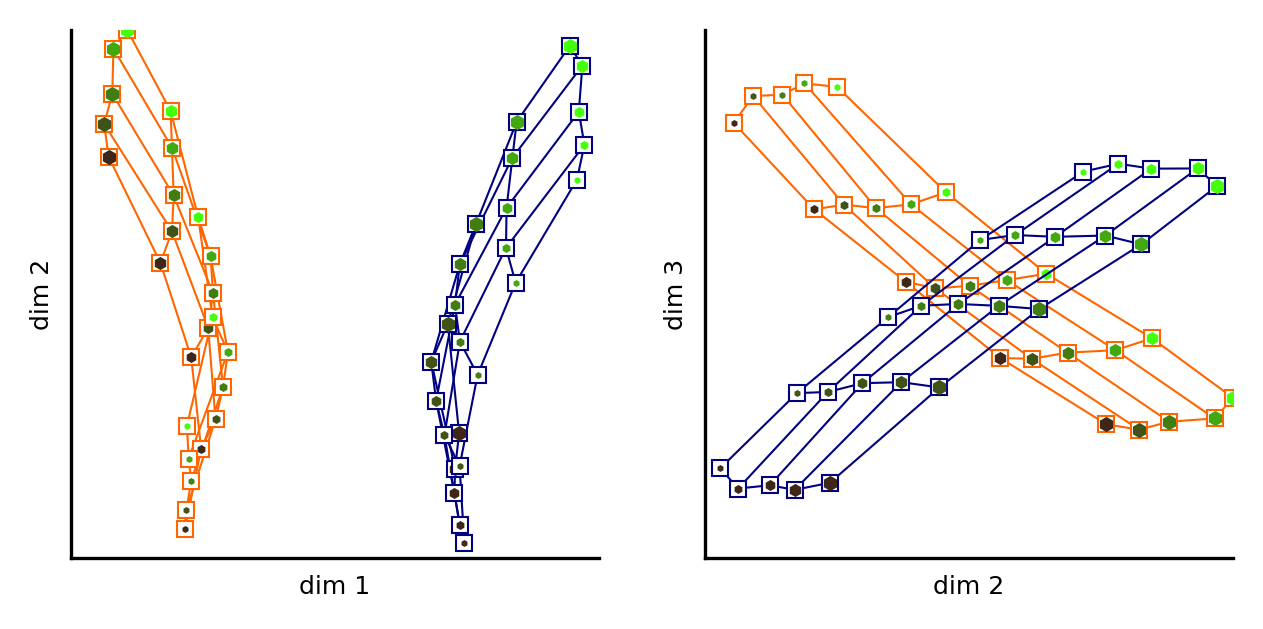

In [55]:
y = np.squeeze(results['all_y_hidden'][0,:,:,:])
y = np.reshape(y,(100*30,50))
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
y = sc.fit_transform(y.T)
print(y.shape)
pca = PCA(n_components=3)
yz = pca.fit_transform(y)
yz /= np.max(yz)

fig = plt.figure(1,facecolor='w',figsize=(5,5),dpi=300)
plot_MDS_embeddings_2D(yz,fig,fig_id=1,axlims=1)

## mds

In [2]:
import math
# helper functions
def rotate_axes(x,y,theta):
    # theta is in degrees
    theta_rad = theta * (math.pi/180)  # convert to radians
    x_new = x * math.cos(theta_rad) + y * math.sin(theta_rad)
    y_new =  -x * math.sin(theta_rad) + y * math.cos(theta_rad)
    return x_new, y_new

def rotate(X, theta, axis='x'):
    '''Rotate multidimensional array `X` `theta` degrees around axis `axis`'''
    theta = theta * (math.pi/180)  # convert to radians
    c, s = np.cos(theta), np.sin(theta)
    if axis == 'x': return np.dot(X, np.array([
        [1.,  0,  0],
        [0 ,  c, -s],
        [0 ,  s,  c]
        ]))
    elif axis == 'y': return np.dot(X, np.array([
        [c,  0,  -s],
        [0,  1,   0],
        [s,  0,   c]
        ]))
    elif axis == 'z': return np.dot(X, np.array([
        [c, -s,  0 ],
        [s,  c,  0 ],
        [0,  0,  1.],
        ]))


In [3]:
# perform mds 
# hidden layer mds of endpoints
dimensionality = 2

y = results['all_y_hidden']
print(y.shape)
rdms = np.empty((2,N_RUNS,50,50))
for ii in range(N_RUNS):
    rdms[0,ii,:,:] = squareform(pdist(y[0,ii,:,:].T,metric='euclidean'))
for ii in range(N_RUNS):
    rdms[1,ii,:,:] = squareform(pdist(y[-1,ii,:,:].T,metric='euclidean'))

labels = ['feature learning regime', 'lazy learning regime']
fig=plt.figure(1,figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(2):
    plt.subplot(1,2,ii+1)
    plt.imshow(np.mean(rdms[ii,:,:,:],0))
    plt.title(labels[ii])


embedding = MDS(n_components=3,n_init=10,max_iter=10000,metric=True)

xyz_rich = embedding.fit_transform(np.mean(rdms[0,:,:,:],0))
xyz_lazy = embedding.fit_transform(np.mean(rdms[1,:,:,:],0))
embeddings = {'rich':xyz_rich, 'lazy':xyz_lazy}




NameError: name 'results' is not defined

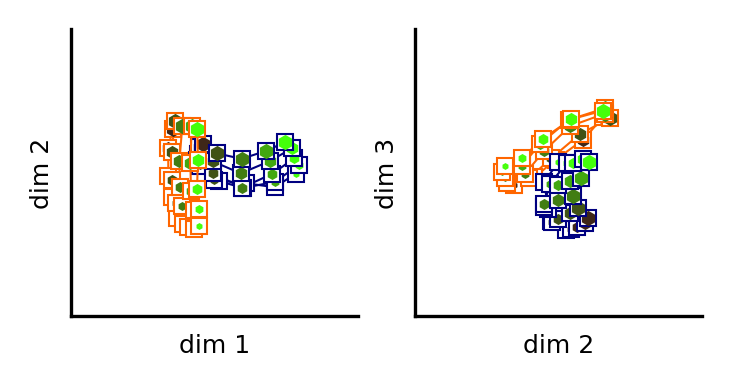

In [27]:
theta_x = 180
theta_y = 280
theta_z = 10+90

xyz_rot = rotate(embeddings['rich'],theta_x,axis='x')
xyz_rot = rotate(xyz_rot,theta_y,axis='y')
xyz_rot = rotate(xyz_rot,theta_z,axis='z')
# xyz_rot[:,2] = -xyz_rot[:,2]
plt.close()
mm = 1/25.4
fig = plt.figure(2,figsize=(69*mm, 33*mm), dpi= 300, facecolor='w', edgecolor='k')

plot_MDS_embeddings_2D(xyz_rot,fig,fig_id=2,axlims=3.5)


## display model rdms + mds

In [4]:

def gen_modelrdms_all(ctx_offset=1):
    models = []
    xyzs = []
    ctx = np.concatenate((ctx_offset*np.ones((25,1)),np.zeros((25,1))),axis=0).reshape(50,1)
    ## model rdms:
    a,b = np.meshgrid(np.linspace(-2,2,5),np.linspace(-2,2,5))
    # grid model
    gridm = np.concatenate((a.flatten()[np.newaxis,:],b.flatten()[np.newaxis,:]),axis=0).T
    gridm = np.concatenate((np.tile(gridm,(2,1)),ctx),axis=1)
    models.append(squareform(pdist(gridm,metric='euclidean')))
    xyzs.append(gridm)

    # rotated grid model 
    gridm = np.concatenate((a.flatten()[np.newaxis,:],b.flatten()[np.newaxis,:]),axis=0).T
    gridm = np.tile(gridm,(2,1))
    gridm[25:, :] = gridm[25:, :] @ np.array([[np.cos(np.deg2rad(270)), -np.sin(np.deg2rad(270))], [np.sin(np.deg2rad(270)), np.cos(np.deg2rad(270))]])
    gridm = np.concatenate((gridm,ctx),axis=1)
    models.append(squareform(pdist(gridm,metric='euclidean')))
    xyzs.append(gridm)

    # orthogonal model
    orthm = np.concatenate((np.concatenate((a.flatten()[np.newaxis,:],np.zeros((1,25))),axis=0).T,
                            np.concatenate((np.zeros((1,25)),b.flatten()[np.newaxis,:]),axis=0).T),axis=0)
    orthm = np.concatenate((orthm,ctx),axis=1)
    models.append(squareform(pdist(orthm,metric='euclidean')))
    xyzs.append(orthm)


    # parallel model 
    a = a.flatten()
    b = b.flatten()

    ta = np.stack((a,np.zeros((25))),axis=1)
    tb = np.stack((np.zeros(25),b),axis=1)
    theta = np.radians(-90)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    parm = np.concatenate((ta.dot(R),tb),axis=0)
    parm = np.concatenate((parm,ctx),axis=1)
    models.append(squareform(pdist(parm,metric='euclidean')))
    xyzs.append(parm)

    # only branchiness model
    obm = np.concatenate((a[:,np.newaxis],a[:,np.newaxis]),axis=0)

    models.append(squareform(pdist(obm,metric='euclidean')))
    obm = np.concatenate((obm,np.zeros((50,2))),axis=1)
    xyzs.append(obm)

    # only leafiness model
    olm = np.concatenate((b[:,np.newaxis],b[:,np.newaxis]),axis=0)
    models.append(squareform(pdist(olm,metric='euclidean')))
    olm = np.concatenate((olm,np.zeros((50,2))),axis=1)

    xyzs.append(olm)
    

    # diagonal model
    ta = np.stack((a,b),axis=1)
    tb = np.stack((a,b),axis=1)
    theta = np.radians(45)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array((c, s))

    diagm = np.concatenate((ta.dot(R),tb.dot(R)),axis=0)[:,np.newaxis]
    
    diagm = np.concatenate((diagm,ctx),axis=1)
    models.append(squareform(pdist(diagm,metric='euclidean')))
    diagm = np.concatenate((diagm,np.zeros((50,1))),axis=1)
    xyzs.append(diagm)



 
    # construct design matrix
    print([x.shape for x in xyzs])
    xyzs = np.asarray(xyzs)
    
    rdms = np.asarray(models)  

    return rdms,xyzs





In [5]:
%matplotlib qt
rdms,xyzs = gen_modelrdms_all()
mds = MDS(n_components=3,dissimilarity='precomputed',max_iter=1000)
for ii,rdm,xyz in zip(np.arange(len(rdms)),rdms,xyzs):
    plt.figure(ii+1)
    plt.imshow(rdm)
    # xyz = mds.fit_transform(r/dm)
    fig = plt.figure((ii+1)*10,dpi=300)
    plot_MDS_embeddings_2D(xyz,fig,fig_id=(ii+1)*10)

[(50, 3), (50, 3), (50, 3), (50, 3), (50, 3), (50, 3), (50, 3)]


In [21]:
fig = plt.figure((ii+1)*10,dpi=300)
plot_MDS_embeddings_2D(xyzs[-1,:,:],fig,fig_id=(ii+1)*10,axlims=3.5)

In [16]:
# display model rdms
%matplotlib qt
_,_,xyz = gen_modelrdms(monitor=0)
xyz /= np.max(xyz)
print(xyz.shape)
plt.close()
mm = 1/25.4
fig = plt.figure(2,figsize=(210*mm, 210*mm), dpi= 300, facecolor='w', edgecolor='k')
plt.figure(2)
# grid model    
plt.subplot(2,3,1)
plot_grid2(xyz[0,0:25,[0,1]].T,line_colour=(255/255,102/255,0),fig_id=2,line_width=1)
plot_grid2(xyz[0,25:,[0,1]].T,line_colour=(0, 0, .5),fig_id=2,line_width=1)
scatter_mds_2(xyz[0,:,[0,1]].T,fig_id=2,task_id='both',marker_scale=2)
ax = plt.gca()
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])    
xls = plt.xticks()[0]
plt.xticks(ticks=[xls[0],xls[-1]],fontsize=14)
yls = plt.yticks()[0]
plt.yticks(ticks=[yls[0],yls[-1]],fontsize=14)
plt.xlabel('Dimension 1',fontsize=14)
plt.ylabel('Dimension 2',fontsize=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
ax.set_aspect('equal', 'box')

plt.title('Grid Model')
plt.subplot(2,3,4)
plot_grid2(xyz[0,0:25,[1,2]].T,line_colour=(255/255,102/255,0),fig_id=2,line_width=1)
plot_grid2(xyz[0,25:,[1,2]].T,line_colour=(0, 0, .5),fig_id=2,line_width=1)
scatter_mds_2(xyz[0,:,[1,2]].T,fig_id=2,task_id='both',marker_scale=2)
ax = plt.gca()
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
xls = plt.xticks()[0]
plt.xticks(ticks=[xls[0],xls[-1]],fontsize=14)
yls = plt.yticks()[0]
plt.yticks(ticks=[yls[0],yls[-1]],fontsize=14)
plt.xlabel('Dimension 2',fontsize=14)
plt.ylabel('Dimension 3',fontsize=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
ax.set_aspect('equal', 'box')


# orthogonal model    
plt.subplot(2,3,2)
plot_grid2(xyz[1,0:25,[1,0]].T,line_colour=(255/255,102/255,0),fig_id=2,line_width=1)
plot_grid2(xyz[1,25:,[1,0]].T,line_colour=(0, 0, .5),fig_id=2,line_width=1)
scatter_mds_2(xyz[1,0:25,[1,0]].T,fig_id=2,task_id='a',marker_scale=2)
scatter_mds_2(xyz[1,25:,[1,0]].T,fig_id=2,task_id='b',marker_scale=2)
ax = plt.gca()
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])    
xls = plt.xticks()[0]
plt.xticks(ticks=[xls[0],xls[-1]],fontsize=14)
yls = plt.yticks()[0]
plt.yticks(ticks=[yls[0],yls[-1]],fontsize=14)
plt.xlabel('Dimension 1',fontsize=14)
plt.ylabel('Dimension 2',fontsize=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
ax.set_aspect('equal', 'box')

plt.title('Orthogonal Model')
plt.subplot(2,3,5)
plot_grid2(xyz[1,0:25,[0,2]].T,line_colour=(255/255,102/255,0),fig_id=2,line_width=1)
plot_grid2(xyz[1,25:,[0,2]].T,line_colour=(0, 0, .5),fig_id=2,line_width=1)
scatter_mds_2(xyz[1,:,[0,2]].T,fig_id=2,task_id='both',marker_scale=2)
ax = plt.gca()
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
xls = plt.xticks()[0]
plt.xticks(ticks=[xls[0],xls[-1]],fontsize=14)
yls = plt.yticks()[0]
plt.yticks(ticks=[yls[0],yls[-1]],fontsize=14)
plt.xlabel('Dimension 2',fontsize=14)
plt.ylabel('Dimension 3',fontsize=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
ax.set_aspect('equal', 'box')


# parallel model    
plt.subplot(2,3,3)
plot_grid2(xyz[2,0:25,[0,1]].T,line_colour=(255/255,102/255,0),fig_id=2,line_width=1)
plot_grid2(xyz[2,25:,[0,1]].T,line_colour=(0, 0, .5),fig_id=2,line_width=1)
scatter_mds_2(xyz[2,:,[0,1]].T,fig_id=2,task_id='both',marker_scale=2)
ax = plt.gca()
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])    
xls = plt.xticks()[0]
plt.xticks(ticks=[xls[0],xls[-1]],fontsize=14)
yls = plt.yticks()[0]
plt.yticks(ticks=[yls[0],yls[-1]],fontsize=14)
plt.xlabel('Dimension 1',fontsize=14)
plt.ylabel('Dimension 2',fontsize=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
ax.set_aspect('equal', 'box')

plt.title('Parallel Model')
plt.subplot(2,3,6)
plot_grid2(xyz[2,0:25,[1,2]].T,line_colour=(255/255,102/255,0),fig_id=2,line_width=1)
plot_grid2(xyz[2,25:,[1,2]].T,line_colour=(0, 0, .5),fig_id=2,line_width=1)
scatter_mds_2(xyz[2,:,[1,2]].T,fig_id=2,task_id='both',marker_scale=2)
ax = plt.gca()
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-1.5,1.5])
xls = plt.xticks()[0]
plt.xticks(ticks=[xls[0],xls[-1]],fontsize=14)
yls = plt.yticks()[0]
plt.yticks(ticks=[yls[0],yls[-1]],fontsize=14)
plt.xlabel('Dimension 2',fontsize=14)
plt.ylabel('Dimension 3',fontsize=14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
ax.set_aspect('equal', 'box')


(3, 50, 3)


# Revisions: CNN

see pipeline_analyse_cnn.ipynb for details

# Revisions: Human Behaviour & fMRI

## behav: congruency 

In [157]:
datadir = 'D:/DPHIL_01_TREES_FMRI/Paper/code/Data/Humans/part3_fmri/behav/scan/'
data = loadmat(datadir+'congruency_analysis_data.mat')
badsubs = np.array([28])-1
data.keys()

congruent_trials = ((1,1),(1,2),(2,1),(2,2),(4,4),(4,5),(5,4),(5,5))
incongruent_trials = ((1,4),(1,5),(2,4),(2,5),(4,1),(4,2),(5,1),(5,2))
# get rid of annoying empty dims (due to conversion from MATLAB to np)
for k,v in data.items():
    if isinstance(data[k],np.ndarray):
        data[k] = v.squeeze()
accs_congruent = []
accs_incongruent = []
rts_congruent = []
rts_incongruent = []
for sid,rid in enumerate(data['rule_id']):
    if sid not in badsubs:
        b = data['branchiness'][sid,:]
        l = data['leafiness'][sid,:]
        acc = data['resp_correct'][sid,:]
        rt = data['resp_rt'][sid,:]
        if rid<3:
            accs_congruent.append(np.mean([np.mean(acc[(b==i) & (l==j)]) for i,j in congruent_trials]))
            accs_incongruent.append(np.mean([np.mean(acc[(b==i) & (l==j)]) for i,j in incongruent_trials]))
            rts_congruent.append(np.nanmean([np.nanmean(rt[(b==i) & (l==j)]) for i,j in congruent_trials]))
            rts_incongruent.append(np.nanmean([np.nanmean(rt[(b==i) & (l==j)]) for i,j in incongruent_trials]))
        else:
            accs_congruent.append(np.mean([np.mean(acc[(b==i) & (l==j)]) for i,j in incongruent_trials]))
            accs_incongruent.append(np.mean([np.mean(acc[(b==i) & (l==j)]) for i,j in congruent_trials]))
            rts_congruent.append(np.nanmean([np.nanmean(rt[(b==i) & (l==j)]) for i,j in incongruent_trials]))
            rts_incongruent.append(np.nanmean([np.nanmean(rt[(b==i) & (l==j)]) for i,j in congruent_trials]))

rts_congruent = np.asarray(rts_congruent)
rts_incongruent = np.asarray(rts_incongruent)
accs_congruent = np.asarray(accs_congruent)
accs_incongruent = np.asarray(accs_incongruent)
rts_congruent *=1000
rts_incongruent *=1000

In [158]:

t,p = ttest_1samp(rts_congruent-rts_incongruent,0)
print(f'congruency effect in RT: \tt(31)={t.round(2)}, p={p.round(3)}')

congruency effect in RT: 	t(31)=-5.11, p=0.0


In [162]:
f, axs = plt.subplots(1,2,figsize=(2,3),dpi=300)
axs = axs.ravel()
axs[0].bar(np.arange(2),[np.nanmean(accs_congruent),np.nanmean(accs_incongruent)],yerr=[np.std(accs_congruent)/np.sqrt(31),np.std(accs_incongruent)/np.sqrt(31)],width=0.6,color=['green','red'])
_ = axs[0].set(xticks=(0,1),xlabel='Trials',ylabel='accuracy (%)',yticks=np.arange(0,1.1,0.25),yticklabels=np.arange(0,101,25),xticklabels=('congruent','incongruent'),ylim=(.5,1),title='Accuracy')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].plot((0,1),(0.95,0.95),'k-',linewidth=0.5)
t,p = ttest_1samp(accs_congruent-accs_incongruent,0)
print(f'congruency effect in accuracy:\t t(31)={t.round(2)}, p={p.round(3)}')
if t > 1.96:
    if p <0.0001:
        ts = '*'*4
    elif p <0.001:
        ts = '*'*3
    elif p<0.01:
        ts = '*'*2
    elif p<0.05:
        ts = '*'
    axs[0].text(.5,0.95,ts,{'fontsize':6,'ha':'center','fontweight':'bold'})

axs[1].bar(np.arange(2),[np.nanmean(rts_congruent),np.nanmean(rts_incongruent)],yerr=[np.std(rts_congruent)/np.sqrt(31),np.std(rts_incongruent)/np.sqrt(31)],width=0.6,color=['green','red'])
_ = axs[1].set(xticks=(0,1),xlabel='Trials',ylabel='reaction time (ms)',xticklabels=('congruent','incongruent'),title='Reaction Time')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].plot((0,1),(990,990),'k-',linewidth=0.5)

t,p = ttest_1samp(rts_congruent-rts_incongruent,0)
print(f'congruency effect in RT: \tt(31)={t.round(2)}, p={p.round(3)}')
if np.abs(t) > 1.96:
    if p <0.0001:
        ts = '*'*4
    elif p <0.001:
        ts = '*'*3
    elif p<0.01:
        ts = '*'*2
    elif p<0.05:
        ts = '*'
    axs[1].text(.5,995,ts,{'fontsize':6,'ha':'center','fontweight':'bold'})
    


congruency effect in accuracy:	 t(31)=2.68, p=0.012
congruency effect in RT: 	t(31)=-5.11, p=0.0


In [71]:
print(f'acc congruent: {np.round(np.mean(accs_congruent),3)} acc incongruent: {np.round(np.mean(accs_incongruent),3)}')
print(f'rt congruent: {(1000*np.nanmean(rts_congruent)).astype(np.int32)} ms,  rt incongruent: {(1000*np.nanmean(rts_incongruent)).astype(np.int32)} ms.')

acc congruent: 0.892 acc incongruent: 0.851
rt congruent: 899 ms,  rt incongruent: 930 ms.


## fMRI: beta weights within cross-validated ROIs

In [23]:
from statsmodels.stats.multitest import multipletests

_,p,_,alp = multipletests([0.04,0.001],alpha=0.05, method='bonferroni')

In [64]:
for roi in ROIs:
    results = loadmat(datadir + 'bmsresults_branchortho_branch_ortho_'+roi+'.mat')
    print(roi+' ' + str(results['pep'].squeeze().round(3)))

leftEVC [0.302 0.489 0.209]
DLPFC [0. 0. 1.]
MCC [0.003 0.002 0.995]
PPC [0. 0. 1.]


## fMRI: nested model comparison

In [115]:
from scipy.stats import norm
%matplotlib qt

SMALL_SIZE = 6
MEDIUM_SIZE = 6
BIGGER_SIZE = 6

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# plot peps and emfs for each ROI
datadir = 'D:/DPHIL_01_TREES_FMRI/Paper/code/Results/Humans/RSA/ROIs/'
ROIs = ['leftEVC','DLPFC','MCC','PPC']

for roi in ROIs:
    results = loadmat(datadir + 'bmsresults_branchortho_branch_ortho_'+roi+'.mat')
    mm = 1/25.4
    
    f,axs = plt.subplots(1,2,figsize=(100*mm,60*mm),dpi=300)
    axs = axs.ravel()    
    axs[0].bar(np.arange(0,3),results['pep'].squeeze())
    axs[0].set(xticks=(0,1,2),xlabel='Model',ylabel=('PEP'),ylim=(0,1))
    axs[0].set_xticklabels(labels=('branch&ortho','branch','ortho'),rotation=90)
    axs[0].plot(np.arange(-1,4),[0.33]*5,'r--')
    axs[0].set_xlim(-0.6,2.6)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    for mod in range(3):
        mu = np.mean(results['emf'][mod,:])
        err = np.std(results['emf'][mod,:])/np.sqrt(31)
        axs[1].bar(mod,mu,yerr=err,color=[0,.4,.4])
        s,p = wilcoxon(results['emf'][mod,:]-0.33,alternative='greater')
        z = norm.isf(p)
        print(f'{roi},\t model {mod+1}: mu={mu:.2f}+-{err:.2f} \t z={z:.2f}, \t p={p:.3f}')
        if z>1.96:
            if p <0.0001:
                ts = '*'*4
            elif p <0.001:
                ts = '*'*3
            elif p<0.01:
                ts = '*'*2
            elif p<0.05:
                ts = '*'
            plt.text(mod,0.9,ts,{'fontsize':6,'ha':'center','fontweight':'bold'})
    axs[1].set(xticks=(0,1,2),xlabel='Model',ylabel=('EMF'),ylim=(0,1))
    axs[1].set_xticklabels(labels=('branch&ortho','branch','ortho'),rotation=90)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    axs[1].plot(np.arange(-1,4),[0.33]*5,'r--')
    axs[1].set_xlim(-0.6,2.6)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    plt.suptitle('RFX-BMS ROI: '+roi)
    plt.tight_layout()
# perform signed rank tests on emfs within each ROI

leftEVC,	 model 1: mu=0.38+-0.08 	 z=0.80, 	 p=0.211
leftEVC,	 model 2: mu=0.50+-0.08 	 z=2.29, 	 p=0.011
leftEVC,	 model 3: mu=0.12+-0.05 	 z=-3.08, 	 p=0.999
DLPFC,	 model 1: mu=0.15+-0.06 	 z=-2.86, 	 p=0.998
DLPFC,	 model 2: mu=0.03+-0.02 	 z=-4.28, 	 p=1.000
DLPFC,	 model 3: mu=0.82+-0.06 	 z=4.51, 	 p=0.000
MCC,	 model 1: mu=0.20+-0.06 	 z=-2.00, 	 p=0.977
MCC,	 model 2: mu=0.07+-0.04 	 z=-3.69, 	 p=1.000
MCC,	 model 3: mu=0.73+-0.07 	 z=4.19, 	 p=0.000
PPC,	 model 1: mu=0.12+-0.05 	 z=-3.08, 	 p=0.999
PPC,	 model 2: mu=0.04+-0.03 	 z=-4.24, 	 p=1.000
PPC,	 model 3: mu=0.84+-0.06 	 z=4.57, 	 p=0.000


## fmri: dimensionality of patterns (scree plot)

In [3]:
datadir = 'D:/DPHIL_01_TREES_FMRI/Paper/code/Results/Humans/RSA/ROIs/'
ROIs = ['leftEVC','DLPFC','MCC','PPC']
rois = ['EVC','DLPFC','MCC','PPC']
mm = 1/25.4
%matplotlib qt
plt.figure(figsize=(5,5))
for roi in ROIs:
    results = loadmat(datadir + 'groupAvg_singular_values_'+roi+'.mat')
    evs = results['all_svs']**2
    evs = evs/ np.sum(evs,1)[:,np.newaxis]
    print(np.where(np.mean(np.cumsum(evs,1),0)>=0.95)[0][0])
    plt.errorbar(np.arange(1,50+1),np.mean(np.cumsum(evs,1),0),marker='.',yerr=np.std(np.cumsum(evs,1),0)/np.sqrt(evs.shape[0]),linewidth=1,markersize=2)
    ax = plt.gca()
    ax.set(xlabel='principal component',ylabel='cumulative explained variance (%)',yticks=np.arange(0.4,1.1,.1),yticklabels=np.round(np.arange(0.4,1.1,.1)*100),title='Dimensionality of voxel patterns')
plt.legend(rois,frameon=False)





9
15
19
19


## fmri: cross-condition decoding

In [ ]:
#TODO

# Revisions: NHP data

## units: heatmaps with all task selective units. and add inferential statistics

In [2]:
# see matlab figures